In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from committee_learning.ode import SphericalSquaredActivationODE
from committee_learning.initial_conditions import RandomNormalInitialConditions
from committee_learning.simulation import NormalizedSphericalConstraintSimulation
from committee_learning.result import SquareODEResult, SimulationResult
import numpy as np

d_list = [1000,5000,10000]
p = 2
k = 2
gamma0 = .2
noise = 1e-3
dt = 1e-3
id = 0

ic = {d:RandomNormalInitialConditions(p,k,d,spherical=True, seed=id) for d in d_list}

### Simulations

In [11]:
sims = [
  NormalizedSphericalConstraintSimulation(d,p,k,noise,ic[d].Wteacher,gamma0,'square',ic[d].W0)
  for d in d_list
]

simrs = {}
for d, sim in zip(d_list, sims):
  print(f'Simulating d = {sim.d}')
  simr = SimulationResult(initial_condition='random-spherical', id = id)
  simr.from_file_or_run(sim,2+np.log10(sim.d),path='computation-database/sim/')
  simrs[d] = simr

Simulating d = 1000


100%|██████████| 90000/90000 [00:51<00:00, 1748.37it/s]


Simulating d = 5000


100%|██████████| 399999/399999 [04:50<00:00, 1375.16it/s]


Simulating d = 10000


### ODE

In [12]:
oders = {}
for d in d_list:
  ode = SphericalSquaredActivationODE(p,k,noise,gamma0,ic[d].P,ic[d].Q,ic[d].M,dt)
  oder = SquareODEResult('random-shperical', id = id)
  oder.from_file_or_run(ode, 2, path='computation-database/ode/')
  oders[d] = oder

100%|██████████| 90000/90000 [00:19<00:00, 4630.51it/s]


### Plot

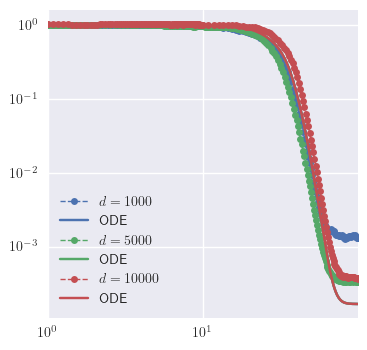

In [13]:
import matplotlib.pyplot as plt
from committee_learning.utilities import plot_style

with plot_style():
  fig, ax = plt.subplots(figsize=(4,4))
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_xlim(1,max(oders[d].times))
  for d in d_list:
    t = np.array(simrs[d].steps) / d
    p, = ax.plot(t, simrs[d].risks, label=f'$d={d}$',ls='--',lw=1.,marker='o',ms=5.)
    ax.plot(oders[d].times, oders[d].risks, label='ODE', c= p.get_color())
  ax.legend()
  plt.show()
  


## Investigating M


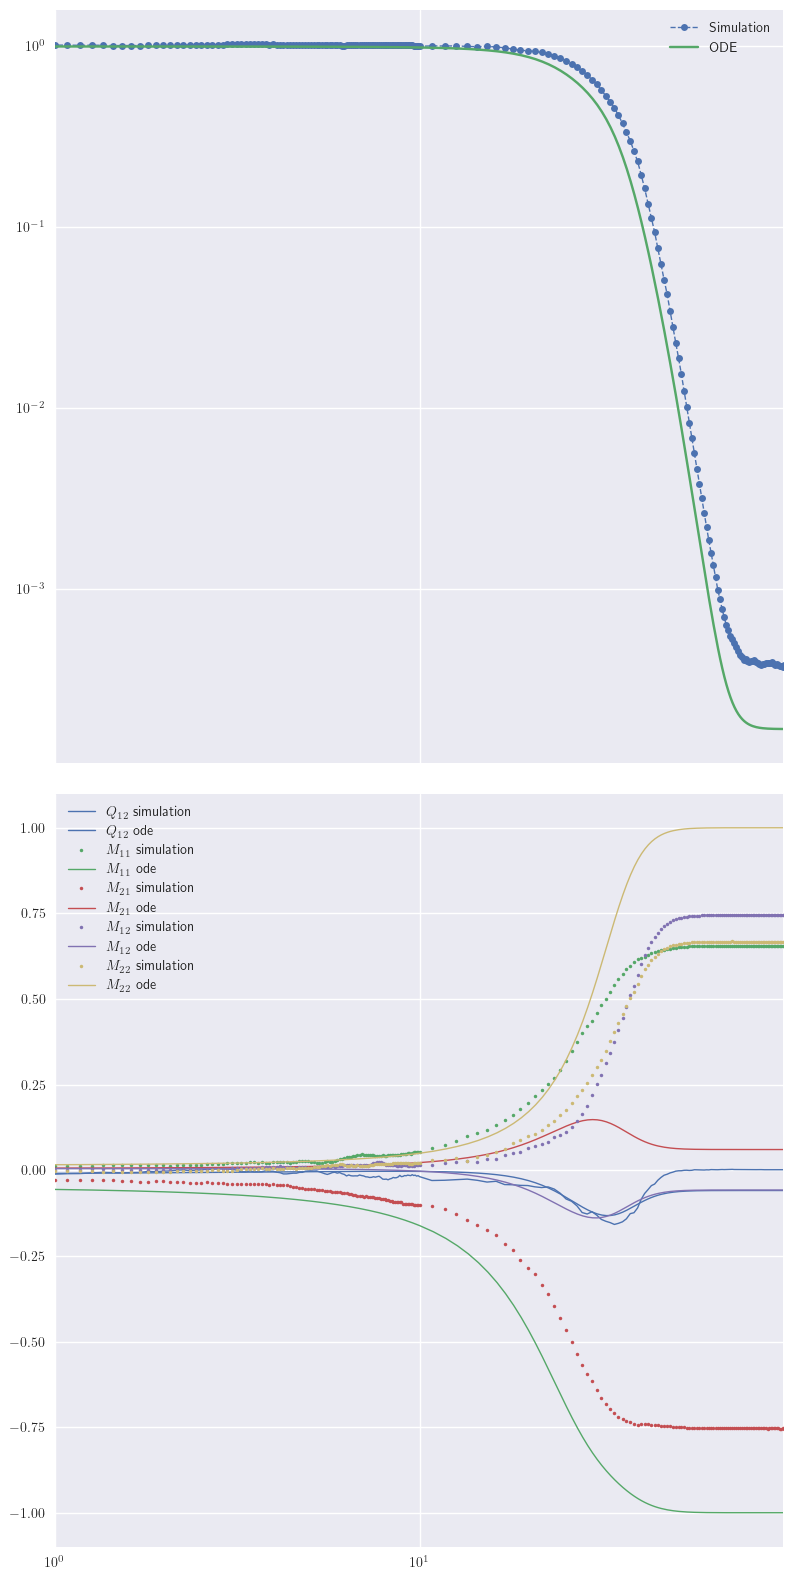

In [14]:
max_d = max(d_list)

sim = simrs[max_d]
ode = oders[max_d]

M_series_sim = np.einsum(
  'tjr->jrt',
  np.array(sim.Ms)
)

M_series_ode = np.einsum(
  'tjr->jrt',
  np.array(ode.Ms)
)

Q_series_sim = np.einsum(
  'tjl->jlt',
  np.array(sim.Qs)
)

Q_series_ode = np.einsum(
  'tjl->jlt',
  np.array(ode.Qs)
)
with plot_style():
  fig, (ax_up, ax_down) = plt.subplots(2,1, figsize=(8,16),sharex=True)
  fig.tight_layout() 

  ax_up.set_xscale('log')
  ax_up.set_yscale('log')
  ax_up.set_xlim(1,max(oders[d].times))
  
  t = np.array(sim.steps) / max_d
  ax_up.plot(t, sim.risks, label=f'Simulation',ls='--',lw=1.,marker='o',ms=5.)
  ax_up.plot(ode.times, oders[d].risks, label='ODE')

  # Q
  for j in range(sim.p):
    for l in range(j+1, sim.p):
      sim_plot, = ax_down.plot(t, Q_series_sim[j][l], label=f'$Q_{{{j+1}{l+1}}}$ simulation',ls='-',lw=1.,marker='',ms=2.5)
      ode_plot, = ax_down.plot(ode.times, Q_series_ode[j][l], label=f'$Q_{{{j+1}{l+1}}}$ ode',ls='-',lw=1.,marker='',ms=2.5, c=sim_plot.get_color())
  

  # # M
  for r in range(sim.k):
    for j in range(sim.p):
      sim_plot, = ax_down.plot(t, M_series_sim[j][r], label=f'$M_{{{j+1}{r+1}}}$ simulation',ls='',lw=1.,marker='o',ms=2.5)
      ode_plot, = ax_down.plot(ode.times, M_series_ode[j][r], label=f'$M_{{{j+1}{r+1}}}$ ode',ls='-',lw=1.,marker='',ms=2.5, c=sim_plot.get_color())
  

  ax_up.legend()
  ax_down.legend()
  plt.show()

In [15]:
from committee_learning.utilities import macroscopic_variable_plot

t = 9e3
simr = simrs[d]

macroscopic_variable_plot(simr.M_at_time(t))
macroscopic_variable_plot(simr.Q_at_time(t))

macroscopic_variable_plot(simr.M_at_time(1e2))
macroscopic_variable_plot(simr.M_at_time(1e3))

ValueError: 90000000 is larger than the largest value in the array 999000